# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

/Users/hanxu/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the functional image of the first subject.

In [2]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [3]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

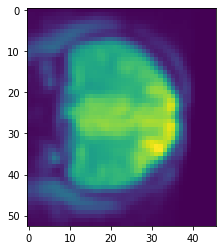

In [4]:
plt.imshow(data.get_fdata()[:,50,:,0])

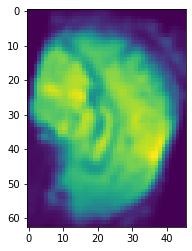

In [5]:
plt.imshow(data.get_fdata()[25,:,:,0])

Let's load the mask data for this subject.

In [6]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [7]:
mask.get_fdata().shape

(53, 63, 46)

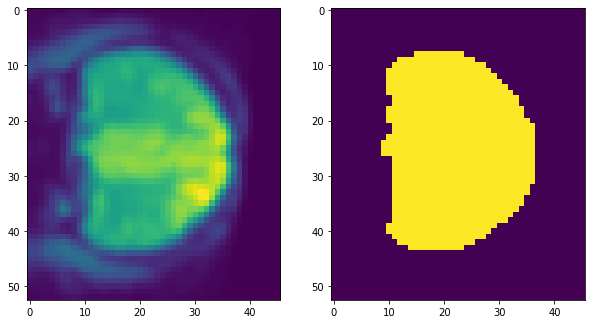

In [8]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

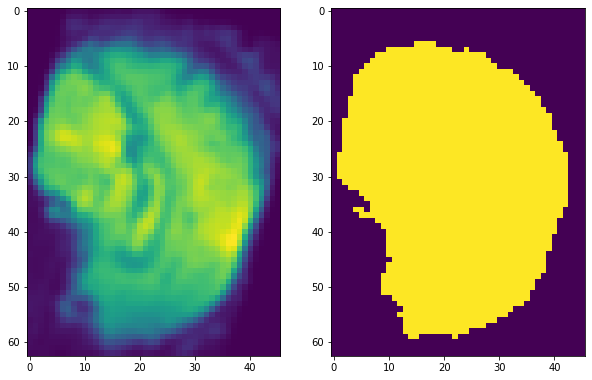

In [9]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

# Exercise 

For each of the question below, use your code to perform the analysis.

## Which regions are more involved with visual compared to auditory sensory processing?

In [10]:
# (seconds)
total_scan_time = 300 # five minutes

# (milliseconds)
onset_times = [0,2400,5700,8700,11400,15000,18000,20700,23700,26700,29700,33000,35400,39000,41700,44700,48000,
        50700,53700,56400,59700,62400,66000,69000,71400,75000,78000,80400,83400,87000,89700,93000,96000,
        99000,102000,105000,108000,110400,113700,116700,119400,122700,125400,129000,131400,135000,137700,
        140400,143400,146700,149400,153000,156000,159000,162000,164400,167700,170400,173700,176700,179700,
        182700,186000,188400,191700,195000,198000,201000,203700,207000,210000,212700,215700,218700,221400,
        224700,227700,230700,234000,236700,240000,243000,246000,248400,251700,254700,257400,260400,264000,
        266700,269700,272700,275400,278400,281700,284400,288000,291000,293400,296700]

# onset type (one-based index)
onset_types = [8,8,11,1,3,10,5,10,4,6,10,2,7,9,9,7,7,11,11,9,
        1,4,11,5,6,9,11,11,7,3,10,11,2,11,11,11,7,11,11,6,
        10,2,8,11,9,7,7,2,3,10,1,8,2,9,3,8,9,4,7,1,
        11,11,11,1,7,9,8,8,2,2,2,6,6,1,8,1,5,3,8,10,
        11,11,9,1,7,4,4,8,2,1,1,11,5,2,11,10,9,5,10,10]

localizer_labels = ['horizontal_checkerboard',
          'vertical_checkerboard',
          'motor_right_auditory',          
          'motor_left_auditory',
          'motor_right_visual',          
          'motor_left_visual',
          'subtraction_auditory',
          'subtraction_visual',          
          'sentence_visual',   
          'sentence_auditory']

def get_localizer_design_data():

    # onset type
    onset_types_0_based = np.array(onset_types) - 1
    
    events = list(zip(onset_times, onset_types_0_based))
    
    # ignore the last onset type
    events = [(onset_time, onset_type) for (onset_time, onset_type) in events if onset_type != 10]
    
    return (events, localizer_labels)

events, labels = get_localizer_design_data()

(128, 10)

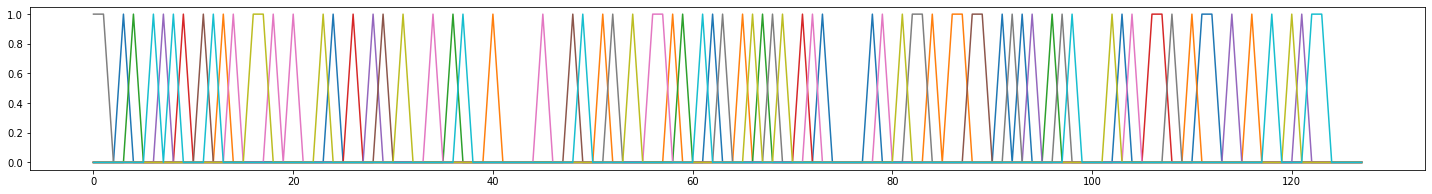

In [11]:
import pandas as pd
def compute_design_vector(events, event_index, n_tr, tr):
    
    selected_onset_times = [onset_time for onset_time, onset_type in events if onset_type == event_index]
        
    iss = np.floor(np.array(selected_onset_times) / (tr * 1000)).astype(int)
                           
    line = np.zeros(n_tr)
        
    line[iss] = 1
    
    return line
def create_design_matrix(events, labels, tr, duration):     
    ### BEGIN SOLUTION
    
    design_matrix = np.zeros((duration, len(labels)),int)
    for i in range(0, len(labels)):
        design_vector_i = compute_design_vector(events, i, duration, tr)
        design_matrix[:,i] = design_vector_i.T
    design_matrix = pd.DataFrame(data=design_matrix, columns=labels)
    
    ### END SOLUTION
    return design_matrix

design_matrix = create_design_matrix(events, labels, 2.4, 128)
plt.figure(figsize=(25,3))
plt.plot(design_matrix);
design_matrix.shape

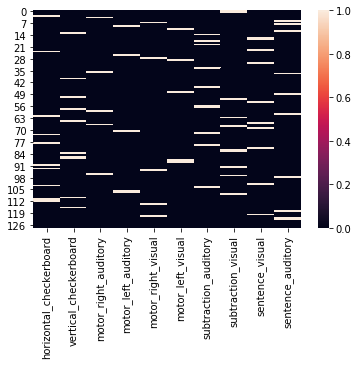

In [12]:
import seaborn as sns
sns.heatmap(design_matrix, xticklabels=design_matrix.columns)

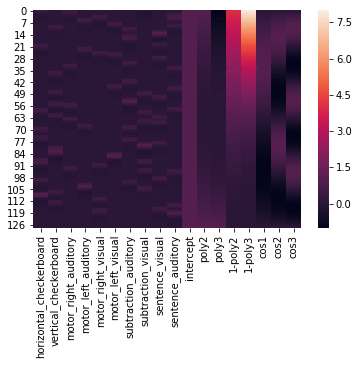

In [13]:
def add_intercept(design_matrix):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    n_rows = design_matrix.shape[0]
    design_matrix_new['intercept'] = np.ones(n_rows)
    return design_matrix_new
    ### END SOLUTION
    
def add_poly(design_matrix, degrees=2, flipped=False):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    time = np.linspace(-1, 1, design_matrix.shape[0])
    if flipped:
        poly = (1-time) ** degrees
        design_matrix_new['1-poly'+str(degrees)] = poly
    else:
        poly = time ** degrees    
        design_matrix_new['poly'+str(degrees)] = poly
    return design_matrix_new

from numpy import sin, pi, arange
def add_cosine(design_matrix, freq, amplitude, phase = 0):         
    duration = design_matrix.shape[0]   
    time = np.linspace(0, 1, duration)
    w = amplitude * sin(2*pi*freq*time + pi*phase)
    copy = design_matrix.copy()
    copy['cos'+str(freq)] = w
    return copy

from nltools.external import glover_hrf
def convolve_hrf(design_matrix, tr):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy()
    hrf = glover_hrf(tr, oversampling=1) 
    labels = design_matrix.columns    
    for label in labels:
        design_matrix_new[label] = np.convolve(design_matrix_new[label].to_numpy(), hrf, mode='same')        
    return design_matrix_new
    ### END SOLUTION
    
def add_many(design_matrix, funcs = []):     
    ### BEGIN SOLUTION
    design_matrix_new = design_matrix.copy() 
    
    for func in funcs:
        design_matrix_new = func(design_matrix_new)
        
    return design_matrix_new
    
    ### END SOLUTION
funcs = [
    lambda dm : convolve_hrf(dm, 2),
    lambda dm : add_intercept(dm),
    lambda dm : add_poly(dm, degrees = 2),
    lambda dm : add_poly(dm, degrees = 3),
    lambda dm : add_poly(dm, degrees = 2, flipped = True),
    lambda dm : add_poly(dm, degrees = 3, flipped = True),  
    lambda dm : add_cosine(dm, 1, 1),
    lambda dm : add_cosine(dm, 2, 1),    
    lambda dm : add_cosine(dm, 3, 1),        
]

design_matrix_new = add_many(design_matrix, funcs)
sns.heatmap(design_matrix_new, xticklabels=design_matrix_new.columns)

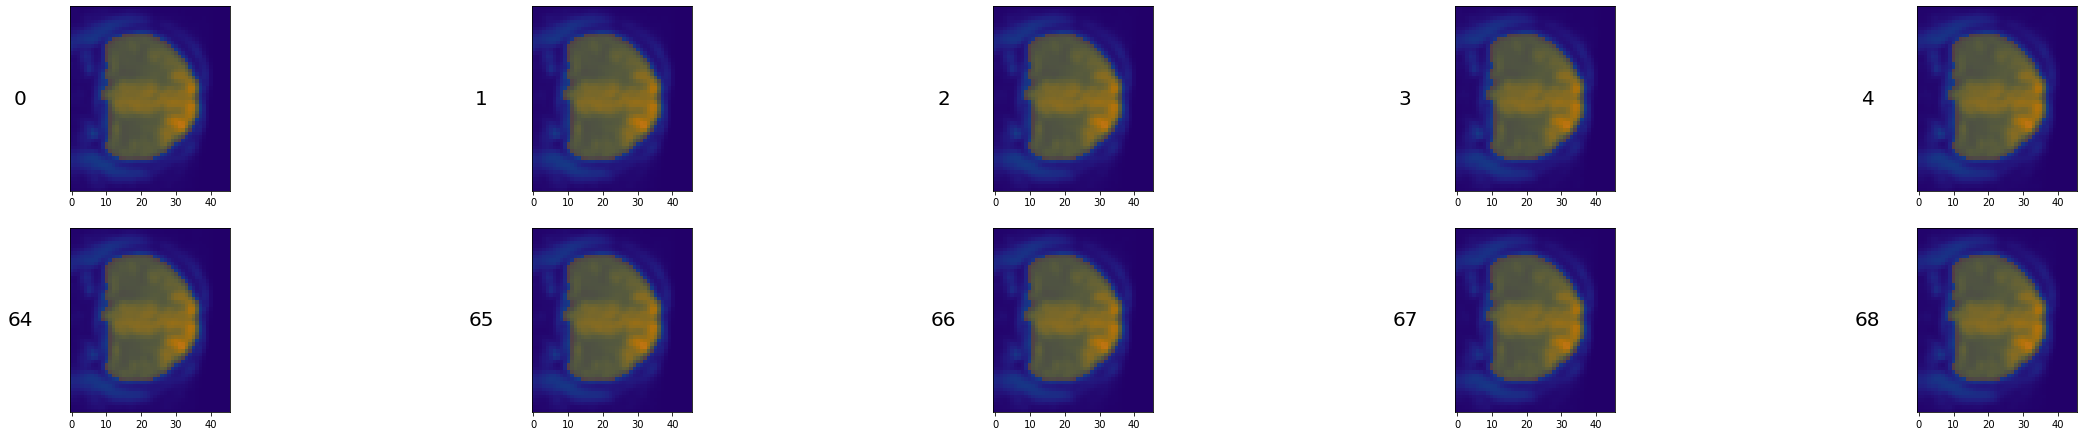

In [14]:
def plot_functional_data_3d(data, dr = 1, frame = 50):
    plt.figure(figsize=(40,40))
    n_tr = data.shape[-1]
    c = int(n_tr/2)
    times = [0,1,2,3,4] + [c,c+1,c+2,c+3,c+4]
    m = len(times)
    for i, time in enumerate(times):
        axes = plt.subplot(m,5,i+1)
        if dr == 0:
            plt.imshow(data.get_fdata()[frame,:,:,time])
            plt.imshow(mask.get_fdata()[frame,:,:], 'jet', alpha=0.5, interpolation='none')
        elif dr == 1:
            plt.imshow(data.get_fdata()[:,frame,:,time])
            plt.imshow(mask.get_fdata()[:,frame,:], 'jet', alpha=0.5, interpolation='none')
        elif dr == 2:
            plt.imshow(data.get_fdata()[:,:,frame,time])
            plt.imshow(mask.get_fdata()[:,:,frame], 'jet', alpha=0.5, interpolation='none')
        plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
        axes.get_yaxis().set_ticks([])
        
plot_functional_data_3d(data)

def plot_functional_data_3d_for_demo(data):
    plt.figure(figsize=(40,40))
    n_tr = data.shape[-1]
    c = int(n_tr/2)
    times = [0,1,2,3,4] + [c,c+1,c+2,c+3,c+4]
    m = len(times)
    for i, time in enumerate([0]):
        axes = plt.subplot(m,5,i+1)
        plt.imshow(data[:,50,:,time])
        plt.ylabel(str(time), fontsize=20, rotation=0, labelpad=50, va='center')
        axes.get_yaxis().set_ticks([])
        


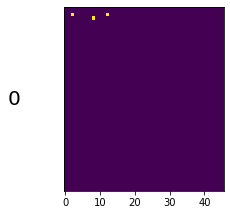

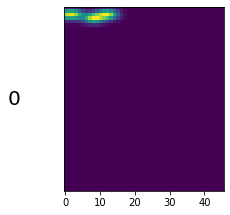

In [15]:
# Try out to see whether estimate_beta works (suppose[1,0,0,0,0,0,0,0,0,0])
# Since get_fdata() cannot work for assigning, just create a variable data_new for demo
# mutate 'data' by adding time series calculated from 'design_matrix' and 'betas' at given 'locations'
#def add(data, design_matrix, betas):  
    #y = np.zeros(design_matrix.shape[0])    
    #for col, beta in zip(design_matrix.columns, betas):
        #y = y + design_matrix[col] * beta
    #data_new = data
    #for i in range(data.get_fdata().shape[0]):
        #for j in range(data.get_fdata().shape[2]):
            #data_new.get_fdata()[i,50,j,:] = y
    #return data_new

def generate_time_series(design_matrix, betas):
    y = np.zeros(design_matrix.shape[0])    
    for col, beta in zip(design_matrix.columns, betas):
        y = y + design_matrix[col] * beta
    return y
def add(data,design_matrix,betas,locations):
    data_new = np.zeros((data.get_fdata().shape[0],data.get_fdata().shape[1],data.get_fdata().shape[2],data.get_fdata().shape[3]))
    for i,j in locations:
        data_new[i,50,j,:] =generate_time_series(design_matrix,betas)
    return data_new

data_new = add(data, design_matrix_new, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],[(2,2),(3,8),(2,12)])
#add(data, design_matrix1, [0,1,0,0,0,0,0,0,0,0], [(5,6),(3,18),(2,20)])
plot_functional_data_3d_for_demo(data_new)

from scipy.ndimage import gaussian_filter1d
def smooth(data):
    data = gaussian_filter1d(data, sigma=2, axis=2, output = data)
    data = gaussian_filter1d(data, sigma=1, axis=1, output = data)
    data = gaussian_filter1d(data, sigma=1, axis=0, output = data)
    return data

data_new = smooth(data_new)
plot_functional_data_3d_for_demo(data_new)

In [16]:
#compute beta map 3D
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
def compute_beta_map(data,design_matrix):
    fir=data.get_fdata().shape[0]
    sec=data.get_fdata().shape[1]
    thi=data.get_fdata().shape[2]
    n_regressors = design_matrix.shape[1]
    N=np.zeros((fir,sec,thi,n_regressors)) 
    for i in range(fir):
        for j in range(sec):
            for k in range(thi):
                Y=data.get_fdata()[i,j,k,:]
                bs=estimate_beta(design_matrix,Y)
                N[i,j,k:]=bs
    return N
def compute_beta_map_for_demo(data,design_matrix):
    fir=data.shape[0]
    sec=data.shape[1]
    thi=data.shape[2]
    n_regressors = design_matrix.shape[1]
    N=np.zeros((fir,sec,thi,n_regressors)) 
    for i in range(fir):
        for j in range(sec):
            for k in range(thi):
                Y=data[i,j,k,:]
                bs=estimate_beta(design_matrix,Y)
                N[i,j,k:]=bs
    return N

beta_map = compute_beta_map_for_demo(data_new, design_matrix_new.values)
beta_map.shape

(53, 63, 46, 18)

In [17]:
beta_map[44,50,44,:]
with np.printoptions(precision=3, suppress=True):
    print(beta_map[2,50,2,:])


[ 0.033 -0.     0.    -0.     0.    -0.    -0.    -0.    -0.     0.
 -0.    -0.     0.     0.     0.     0.    -0.    -0.   ]


In [18]:
X = design_matrix_new.values
Y = data_new[2,50,2,:]
#design_matrix_new
b = estimate_beta(X,Y)
with np.printoptions(precision=3, suppress=True):
    print(b)

[ 0.033 -0.     0.    -0.     0.    -0.    -0.    -0.    -0.     0.
 -0.    -0.     0.     0.     0.     0.    -0.    -0.   ]


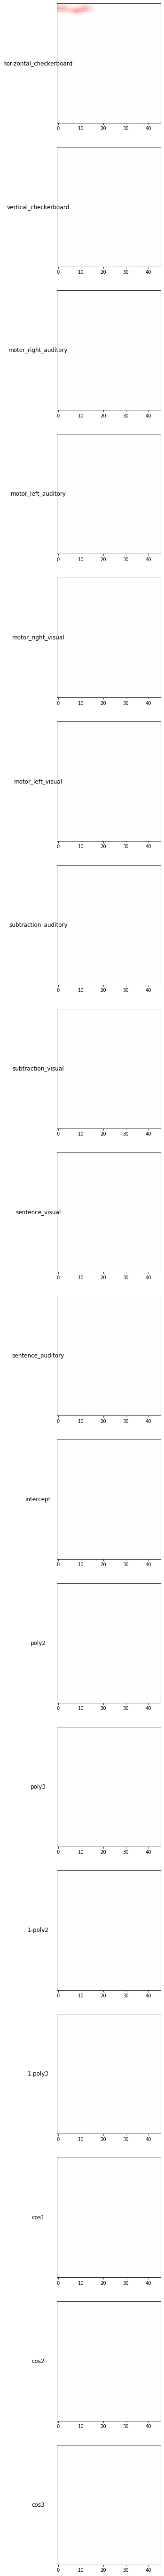

In [19]:
def plot_beta_map_for_demo(beta_map, design_matrix):
    plt.figure(figsize=(100,100))
    labels = design_matrix.columns
    m = len(labels) 
    for i, label in enumerate(labels):
        axes = plt.subplot(m,1,i+1)
        plt.imshow(10*beta_map[:,50,:,i], cmap='bwr', vmin=-1, vmax=1)
        plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
        axes.get_yaxis().set_ticks([])
plot_beta_map_for_demo(beta_map, design_matrix_new)
#np.nonzero(beta_map)

def plot_beta_map(beta_map, design_matrix, dr = 1, frame = 50):
    plt.figure(figsize=(100,100))
    labels = design_matrix.columns
    m = len(labels) 
    for i, label in enumerate(labels):
        axes = plt.subplot(m,1,i+1)
        if dr == 0:
            plt.imshow(beta_map[frame,:,:,i])
            plt.imshow(mask.get_fdata()[frame,:,:], 'jet', alpha=0.5, interpolation='none')
        elif dr == 1:
            plt.imshow(beta_map[:,frame,:,i])
            plt.imshow(mask.get_fdata()[:,frame,:], 'jet', alpha=0.5, interpolation='none')
        elif dr == 2:
            plt.imshow(beta_map[:,:,frame,i])
            plt.imshow(mask.get_fdata()[:,:,frame], 'jet', alpha=0.5, interpolation='none')
        plt.ylabel(label, fontsize=12, rotation=0, labelpad=40, va='center')
        axes.get_yaxis().set_ticks([])


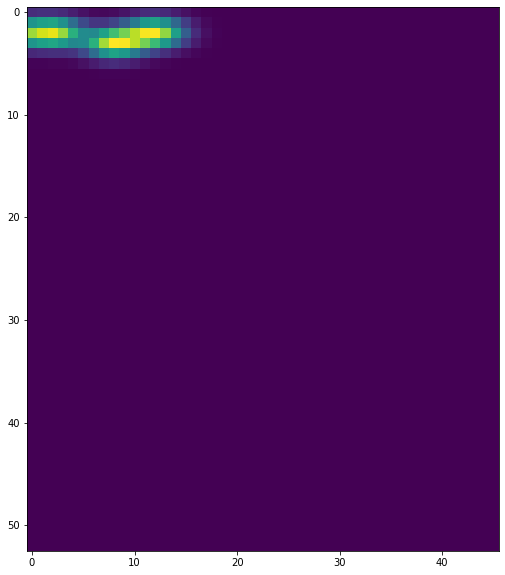

In [20]:
def compute_contrast(beta_map, contrast):         
    b = np.squeeze(beta_map)      
    c = np.array(contrast).T
    cs = np.dot(b,c)
    return cs

def show_contrast_without_mask(beta_map, contrast, dr = 1, frame = 50):
    cs = compute_contrast(beta_map, contrast)
    plt.figure(figsize=(40,10))
    if dr == 0:
        plt.imshow(cs[frame,:,:])
    elif dr == 1:
        plt.imshow(cs[:,frame,:])
    elif dr == 2:
        plt.imshow(cs[:,:,frame])
        
def show_contrast(beta_map, contrast, dr = 1, frame = 50):
    cs = compute_contrast(beta_map, contrast)
    plt.figure(figsize=(40,10))
    if dr == 0:
        plt.imshow(cs[frame,:,:])
        plt.imshow(mask.get_fdata()[frame,:,:], 'jet', alpha=0.5, interpolation='none')
    elif dr == 1:
        plt.imshow(cs[:,frame,:])
        plt.imshow(mask.get_fdata()[:,frame,:], 'jet', alpha=0.5, interpolation='none')
    elif dr == 2:
        plt.imshow(cs[:,:,frame])
        plt.imshow(mask.get_fdata()[:,:,frame], 'jet', alpha=0.5, interpolation='none')
        
def show_contrast_threshold(beta_map, contrast, dr = 1, frame = 50, threshold = 0.9):
    cs = compute_contrast(beta_map, contrast)
    maximum = cs.max()
    cs[cs < maximum*threshold] = 0
    plt.figure(figsize=(40,10))
    if dr == 0:
        plt.imshow(cs[frame,:,:])
        plt.imshow(mask.get_fdata()[frame,:,:], 'jet', alpha=0.5, interpolation='none')
    elif dr == 1:
        plt.imshow(cs[:,frame,:])
        plt.imshow(mask.get_fdata()[:,frame,:], 'jet', alpha=0.5, interpolation='none')
    elif dr == 2:
        plt.imshow(cs[:,:,frame])
        plt.imshow(mask.get_fdata()[:,:,frame], 'jet', alpha=0.5, interpolation='none')
    
    
    
cs = compute_contrast(beta_map, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
cs.shape
show_contrast_without_mask(beta_map,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

In [35]:
def ShowSlicesAcrossAxis(data, axis, numberOfSlices, steps):
    if axis == 'x':
        plt.figure(figsize=(20, 20))
        for i in range(numberOfSlices):
            if i*steps < data.shape[0]:
                plt.subplot(math.ceil(numberOfSlices/5),5,i+1)
                plt.imshow(data[i*steps,:,:], interpolation='none')
                plt.text(data.shape[1]-50, data.shape[2]-20, 'x=' +str(i*steps), color='white')
            else:
                break
        plt.show()
        
    if axis == 'y':
        plt.figure(figsize=(20, 20))
        for i in range(numberOfSlices):
            if i*steps < data.shape[1]:
                plt.subplot(math.ceil(numberOfSlices/5),5,i+1)
                plt.imshow(data[:,i*steps,:], interpolation='none')
                plt.text(data.shape[2]-50, data.shape[0]-20, 'y=' +str(i*steps), color='white')
            else:
                break
        plt.show()
        
    if axis == 'z':
        plt.figure(figsize=(20, 20))
        for i in range(numberOfSlices):
            if i*steps < data.shape[2]:
                plt.subplot(math.ceil(numberOfSlices/5),5,i+1)
                plt.imshow(data[:,:,i*steps], interpolation='none')
                plt.text(data.shape[1]-50, data.shape[0]-20, 'z=' +str(i*steps), color='white')
            else:
                break
        plt.show()

In [100]:
def ShowLocation(data, x, y, z):
    #check boundaries
    #if abs(x) > data.shape[0]/2 or abs(y) > data.shape[1]/2 or abs(y) > data.shape[2]/2:
        #print("Out of boundaries.")
        #return
    #interpret x, y, z relative to the center of the data    
    abs_x = x
    abs_y = y
    abs_z = z
    
    #plot
    
    f, axs = plt.subplots(1,3,figsize=(10,10),gridspec_kw={'width_ratios': [1,data.shape[1]/data.shape[0],1]})
    
    #plt.subplot(1,3,2)
    
    axs[1].imshow(np.rot90(data[abs_x,:,:],1), interpolation='none')
    #axs[1].text(5,250,'x = '+str(x))
    axs[1].axhline(abs_z,color='white')
    axs[1].axvline(abs_y,color='white')
    
    #plt.subplot(1,3,1)
    axs[0].imshow(np.rot90(data[:,abs_y,:],1),  interpolation='none')
    #axs[0].text(5,250,'y ='+str(y))
    #axs[0].text(5,15,'L')
    #axs[0].text(175,15,'R')
    axs[0].axhline(abs_z)
    axs[0].axvline(abs_x)

    #plt.subplot(1,3,3)
    axs[2].imshow(np.rot90(data[:,:,abs_z],1), interpolation='none')
    #axs[2].text(5,250,'z ='+str(z))
    #axs[2].text(5,15,'L')
    #axs[2].text(175,15,'R')
    #axs[2].axis('off')
    axs[2].axhline(abs_y)
    axs[2].axvline(abs_x)
    
    f.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [21]:
#apply on real data
# step 1: compute beta map 
beta_map_real = compute_beta_map(data, design_matrix_new.values)
beta_map.shape

(53, 63, 46, 18)

In [45]:
# step 2: plot beta map
#plot_beta_map(beta_map_real, design_matrix_new)


/Users/hanxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


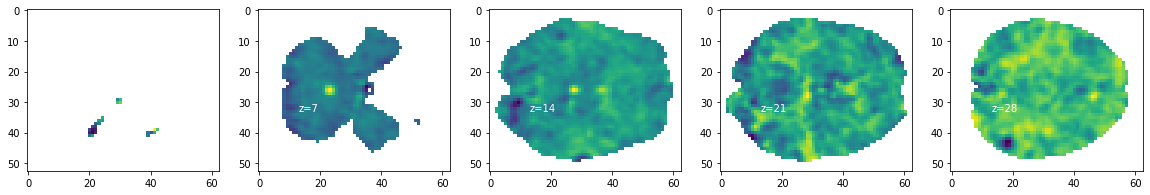

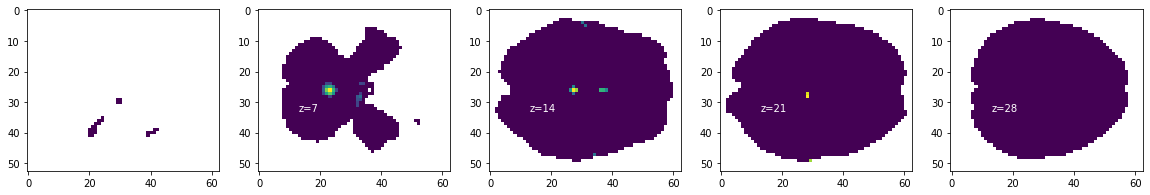

In [54]:
# step 3: compute contrast
#cs = compute_contrast(beta_map_real, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
#cs.shape
#show_contrast_without_mask(beta_map_real,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dr = 1, frame = 50)
#show_contrast(beta_map_real,[1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], dr = 1, frame = 50)
#ShowSlicesAcrossAxis(cs, 'z', 20, 2)
visualize_contrast(beta_map_real, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], mask.get_fdata(), 'z', 5,7 )
visualize_contrast_withThreshold(beta_map_real, [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], mask.get_fdata(), 'z', 5,7,0.1 )

In [57]:
def generateContrast(dm, t1, t2):
    labels = dm.columns
    contrast = np.zeros(len(labels))
    t1_all = []
    t2_all = []
    if '+' in  t1:
        t1_all = t1.split('+')
    else:
        t1_all = [t1]
    if '+' in t2:
        t2_all = t2.split('+')
    else:
        t2_all = [t2]
    t1_flag = False
    t2_flag = False
    for i, label in enumerate(labels):
        for t1i in t1_all:
            if t1i in label:
                contrast[i] = 0.5
                break
                
        for t2i in t2_all:
            if t2i in label:
                contrast[i] = -0.5
                break
        
        #if t1 in label:
            #contrast[i] = 0.5
        #if t2 in label:
            #contrast[i] = -0.5
    return contrast
    
def generateRegion(data, dm, contrast, axis, numberOfSlices, steps, threshold):
    # step 1: compute beta map 
    beta_map_real = compute_beta_map(data, dm.values)
    print(beta_map.shape)
    
    # step 2: plot beta map
    #plot_beta_map(beta_map_real, dm, dr, frame)
    
    # step 3: compute contrast and visualize
    #cs = compute_contrast(beta_map_real, contrast)
    #print(cs.shape)
    #show_contrast_without_mask(beta_map_real,contrast,dr,frame)
    #show_contrast(beta_map_real,contrast, dr,frame)
    #show_contrast_threshold(beta_map_real, contrast, dr, frame, 0.1)
    visualize_contrast(beta_map_real, contrast, mask.get_fdata(), axis, numberOfSlices, steps )
    visualize_contrast_withThreshold(beta_map_real, contrast, mask.get_fdata(), axis, numberOfSlices, steps, threshold )

    

In [56]:
contrast = generateContrast(design_matrix_new, 'visual', 'auditory')
contrast

array([ 0. ,  0. , -0.5, -0.5,  0.5,  0.5, -0.5,  0.5,  0.5, -0.5,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ])

(53, 63, 46, 18)


/Users/hanxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


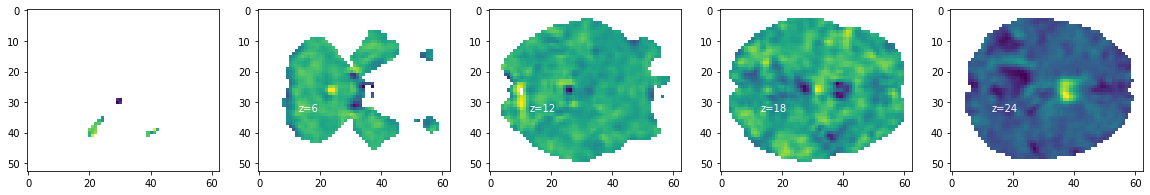

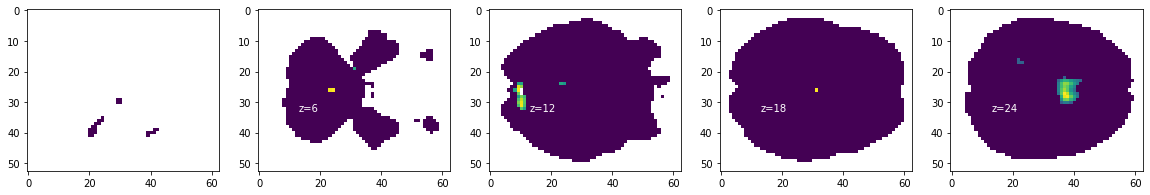

In [58]:
generateRegion(data, design_matrix_new, contrast, 'z', 5, 6, 0.1)

In [59]:
#show_contrast_threshold(beta_map_real, contrast,1,50,0)

## Which regions are more involved in processing numbers compared to words?

[ 0.   0.   0.   0.   0.   0.   0.5  0.5 -0.5 -0.5  0.   0.   0.   0.
  0.   0.   0.   0. ]
(53, 63, 46, 18)


/Users/hanxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


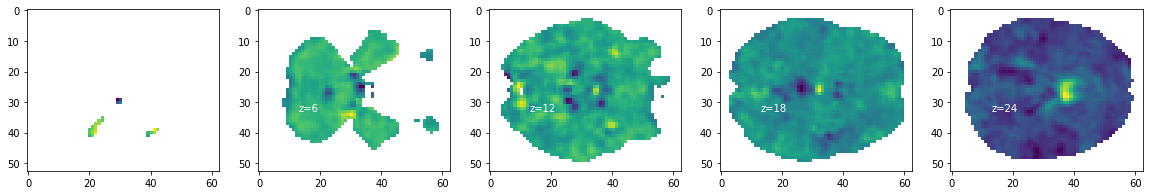

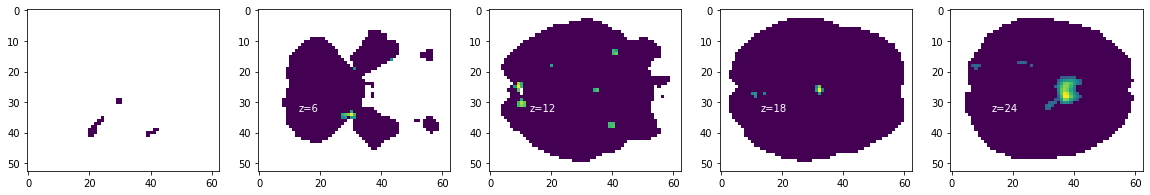

In [60]:
contrast = generateContrast(design_matrix_new, 'subtraction', 'sentence')
print(contrast)
generateRegion(data, design_matrix_new, contrast, 'z', 5, 6, 0.1)

## Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?

[ 0.   0.   0.5  0.5  0.5  0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
  0.   0.   0.   0. ]
(53, 63, 46, 18)


/Users/hanxu/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


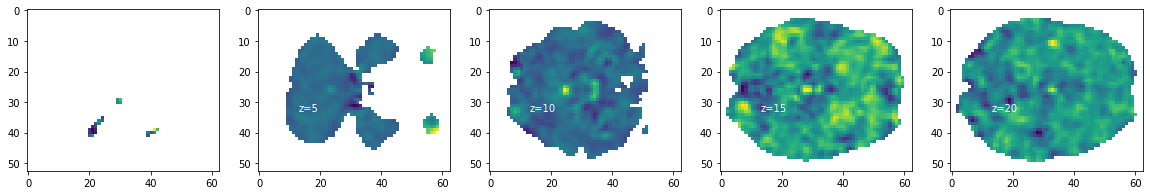

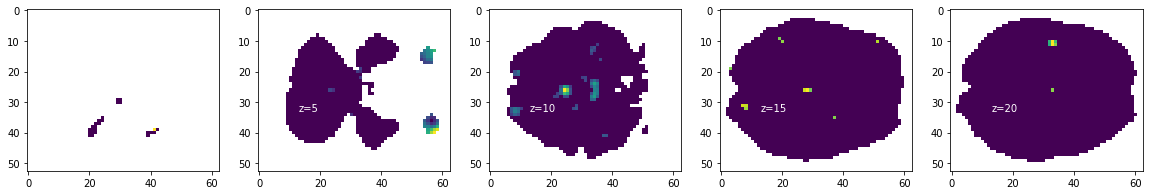

In [71]:
contrast = generateContrast(design_matrix_new, 'motor', 'sentence+subtraction')
print(contrast)
generateRegion(data, design_matrix_new, contrast, 'z', 5, 5, 0.1)

In [ ]:
# can do the smmoth to joint the whole region, or dilation/erosion

In [149]:
def find_most_active_slices_xyz(bcmap):
    max_sum_x = np.NINF
    max_sum_y = np.NINF
    max_sum_z = np.NINF
    num_x = np.NINF
    num_y = np.NINF
    num_z = np.NINF
    

    for num_slice in range(bcmap.shape[0]):
        slice_sum = np.sum(bcmap[num_slice,:,:])
        if slice_sum > max_sum_x:
            max_sum_x = slice_sum
            num_x = num_slice
    
    for num_slice in range(bcmap.shape[1]):
        slice_sum = np.sum(bcmap[:,num_slice,:])
        if slice_sum > max_sum_y:
            max_sum_y = slice_sum
            num_y = num_slice
    
    for num_slice in range(bcmap.shape[2]):
        slice_sum = np.sum(bcmap[:,:,num_slice])
        if slice_sum > max_sum_z:
            max_sum_z = slice_sum
            num_z = num_slice
                    
    return num_x, num_y, num_z

def find_most_active_slices_xyz_beta(bcmap,event):
    max_sum_x = np.NINF
    max_sum_y = np.NINF
    max_sum_z = np.NINF
    num_x = np.NINF
    num_y = np.NINF
    num_z = np.NINF
    

    for num_slice in range(bcmap.shape[0]):
        slice_sum = np.sum(bcmap[num_slice,:,:,event])
        if slice_sum > max_sum_x:
            max_sum_x = slice_sum
            num_x = num_slice
    
    for num_slice in range(bcmap.shape[1]):
        slice_sum = np.sum(bcmap[:,num_slice,:,event])
        if slice_sum > max_sum_y:
            max_sum_y = slice_sum
            num_y = num_slice
    
    for num_slice in range(bcmap.shape[2]):
        slice_sum = np.sum(bcmap[:,:,num_slice,event])
        if slice_sum > max_sum_z:
            max_sum_z = slice_sum
            num_z = num_slice
                    
    return num_x, num_y, num_z

def getMasked(cs, mask, threshold):
    masked = np.multiply(cs, mask)
    masked[masked_contrast == 0] = np.NINF
    
    maximum = masked.max()
    
    masked[masked<= threshold*maximum] = 1
    masked[mask == 0] = np.NINF
    return masked

def getMaskedContrast(cs,mask,threshold):
    masked_contrast = np.multiply(cs, mask)
    #masked_contrast[masked_contrast == 0] = np.NINF
    
    maximum = masked_contrast.max()
    
    masked_contrast[masked_contrast<= threshold*maximum] = 0
    #masked_contrast[mask == 0] = np.NINF
    return masked_contrast

In [118]:
# sliders to explore slices
# sliders to explore slices with the most active slices as default

def visualize_contrast_withThreshold_Interactive(masked_contrast, axis, numberOfSlices, steps):
    ShowSlicesAcrossAxis(masked_contrast, axis, numberOfSlices, steps)
    
def visualiza_contrast_withLocation_Interactive(masked_contrast, x,y,z):
    ShowLocation(masked_contrast, x, y, z)
    
def visualize_beta_withLocation_Interactive(masked_beta, x,y,z):
    ShowLocation(masked_contrast, x, y, z)
    
from ipywidgets import interact_manual, interact

contrast = generateContrast(design_matrix_new, 'motor', 'sentence+subtraction')
print(contrast)

beta_map_real = compute_beta_map(data, design_matrix_new.values)
print(beta_map.shape)

cs = compute_contrast(beta_map_real, contrast)
    

[ 0.   0.   0.5  0.5  0.5  0.5 -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.
  0.   0.   0.   0. ]
(53, 63, 46, 18)


In [144]:
masked_contrast = getMaskedContrast(cs, mask.get_fdata(),0.1)
masked = getMasked(cs, mask.get_fdata(),0.1)
masked_contrast.shape

(53, 63, 46)

In [157]:
masked_contrast_beta = getMaskedContrast(beta_map_real[:,:,:,1], mask.get_fdata(),0.1)
masked_beta = getMasked(beta_map_real[:,:,:,1], mask.get_fdata(),0.1)
masked_contrast_beta.shape

(53, 63, 46)

interactive(children=(Dropdown(description='axis', options=('z', 'y', 'x'), value='z'), IntSlider(value=5, des…

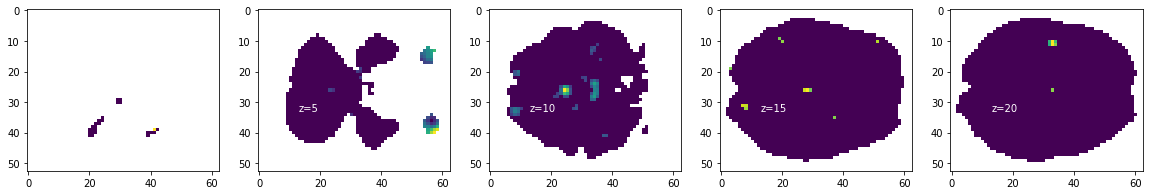

In [147]:
@interact(axis = ['z','y','x'], numberOfSlices = (0,63), steps=(0,10),)
def interactiveVisualization(axis = 'z',numberOfSlices = 5, steps = 5, threshold=0.1):
    visualize_contrast_withThreshold_Interactive(masked, axis, numberOfSlices, steps)

26 56 5


interactive(children=(IntSlider(value=26, description='x', max=53), IntSlider(value=56, description='y', max=6…

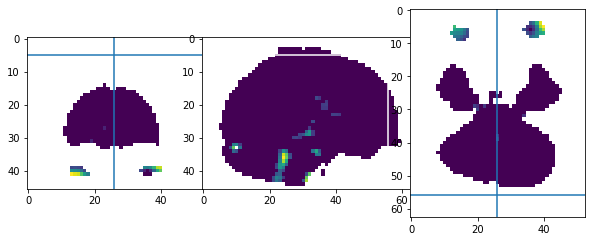

In [146]:
xm,ym,zm= find_most_active_slices_xyz(masked_contrast)
print(xm,ym,zm)
@interact(x=(0,data.get_fdata().shape[0]), y=(0,data.get_fdata().shape[1]), z=(0,data.get_fdata().shape[2]))
def interact_with_voxels(x=xm, y=ym, z=zm):
    visualiza_contrast_withLocation_Interactive(masked, x,y,z)

26 21 36


interactive(children=(IntSlider(value=26, description='x', max=53), IntSlider(value=21, description='y', max=6…

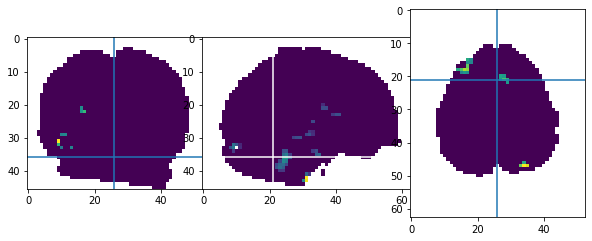

In [158]:
xmb,ymb,zmb= find_most_active_slices_xyz_beta(beta_map_real,1)
print(xmb,ymb,zmb)
@interact(x=(0,data.get_fdata().shape[0]), y=(0,data.get_fdata().shape[1]), z=(0,data.get_fdata().shape[2]))
def interact_with_voxels(x=xmb, y=ymb, z=zmb):
    visualiza_contrast_withLocation_Interactive(masked_beta, x,y,z)

In [262]:
from scipy import ndimage
struct = ndimage.generate_binary_structure(2, 1)
#struct
arr = np.zeros([3,3])
arr[1,1] = 1
arr

array([[0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.]])

In [181]:
def getMaskedClustering_todraw(cs, mask, threshold,stru):
    masked = np.multiply(cs, mask)
    masked[masked_contrast == 0] = np.NINF
    
    maximum = masked.max()
    
    masked[masked<= threshold*maximum] = 1
    for i in range(masked.shape[0]):
        masked[i,:,:] = ndimage.grey_dilation(masked[i,:,:], structure=stru).astype(masked.dtype)
    for i in range(masked.shape[1]):
        masked[:,i,:] = ndimage.grey_dilation(masked[:,i,:], structure=stru).astype(masked.dtype)
    for i in range(masked.shape[2]):
        masked[:,:,i] = ndimage.grey_dilation(masked[:,:,i], structure=stru).astype(masked.dtype)
    masked[mask == 0] = np.NINF
    return masked

def getMaskedClustering(cs,mask,threshold,stru):
    masked_contrast = np.multiply(cs, mask)
    #masked_contrast[masked_contrast == 0] = np.NINF
    
    maximum = masked_contrast.max()
    
    masked_contrast[masked_contrast<= threshold*maximum] = 0
    for i in range(masked_contrast.shape[0]):
        masked_contrast[i,:,:] = ndimage.grey_dilation(masked_contrast[i,:,:], structure=stru).astype(masked_contrast.dtype)
    for i in range(masked_contrast.shape[1]):
        masked_contrast[:,i,:] = ndimage.grey_dilation(masked_contrast[:,i,:], structure=stru).astype(masked_contrast.dtype)
    for i in range(masked_contrast.shape[2]):
        masked_contrast[:,:,i] = ndimage.grey_dilation(masked_contrast[:,:,i], structure=stru).astype(masked_contrast.dtype)
    #masked_contrast[mask == 0] = np.NINF
    return masked_contrast

In [213]:
masked_contrast_dilation = getMaskedClustering(cs, mask.get_fdata(),0.1, struct)
masked_dilation = getMaskedClustering_todraw(cs, mask.get_fdata(),0.1,struct)
masked_contrast_dilation.shape
#ndimage.grey_dilation(masked[1,:,:], footprint = struct).astype(masked_contrast.dtype)
#masked_contrast

(53, 63, 46)

25 34 4


interactive(children=(IntSlider(value=25, description='x', max=53), IntSlider(value=34, description='y', max=6…

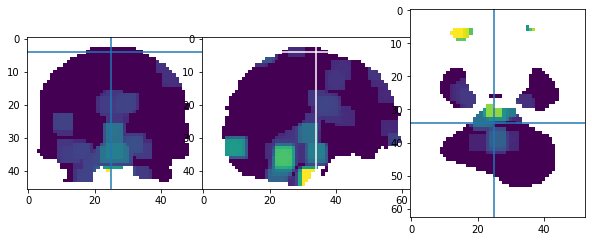

In [218]:
xm_d,ym_d,zm_d= find_most_active_slices_xyz(masked_contrast_dilation)
print(xm_d,ym_d,zm_d)
@interact(x=(0,data.get_fdata().shape[0]), y=(0,data.get_fdata().shape[1]), z=(0,data.get_fdata().shape[2]))
def interact_with_voxels(x=xm_d, y=ym_d, z=zm_d):
    visualiza_contrast_withLocation_Interactive(masked_dilation, x,y,z)

In [251]:
from scipy import signal
def getCoor(dilation_map, stru, axis, index):
    m = len(stru)
    n = len(stru[0])
    stru1 = np.ones([m,n])
    max_sum = float('-inf')
    ind = -1
    if axis == 'x':
        convolved = signal.convolve2d(dilation_map[index,:,:],stru1)  
        #ind = np.unravel_index(np.argmax(convolved, axis=None), convolved.shape)
    if axis == 'y':
        convolved = signal.convolve2d(dilation_map[:,index,:],stru1) 
        #ind = np.unravel_index(np.argmax(convolved, axis=None), convolved.shape)
    if axis == 'z':
        convolved = signal.convolve2d(dilation_map[:,:,index],stru1)  
        #ind = np.unravel_index(np.argmax(convolved, axis=None), convolved.shape)
        
    for i in range(convolved.shape[0]):
            for j in range(convolved.shape[1]):
                if convolved[i,j] > max_sum:
                    max_sum = convolved[i,j]
                    ind = (i,j)
    
    return convolved, ind
#convolved

In [221]:
#masked_contrast_dilation

In [255]:
c, index = getCoor(masked_contrast_dilation, struct, 'x', 24)

In [256]:
c

array([[ 3.,  6.,  9., ...,  9.,  6.,  3.],
       [ 6., 12., 18., ..., 18., 12.,  6.],
       [ 9., 18., 27., ..., 27., 18.,  9.],
       ...,
       [ 9., 18., 27., ..., 27., 18.,  9.],
       [ 6., 12., 18., ..., 18., 12.,  6.],
       [ 3.,  6.,  9., ...,  9.,  6.,  3.]])

In [257]:
index

(33, 4)